In [1]:
import sys
from pathlib import Path
import rasterio
import pyodbc
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.windows import from_bounds
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

project_root = Path.cwd().resolve().parent  
sys.path.insert(0, str(project_root))

from peakfinder.modules.tree_tops import *

#for database connection
from peakfinder.modules.field_data import *


In [5]:
# Path to save the nDSM
output_ndsm = r"D:\Drohnendaten\19_W007\Ecke_Baumhöhen\TEMP\EBE_151_20240925_nDSM.tif"
#dsm_file = r"D:\Drohnendaten\TEMP\Baumhoehen\EBE_151_20240925_DSM_clipped_v3.tif"
#dtm_file = "D:\Drohnendaten\TEMP\Baumhoehen\EBE_151_DTM_clipped_v3.tif"

#ndsm = calculate_ndsm(dsm_file, dtm_file, output_ndsm)

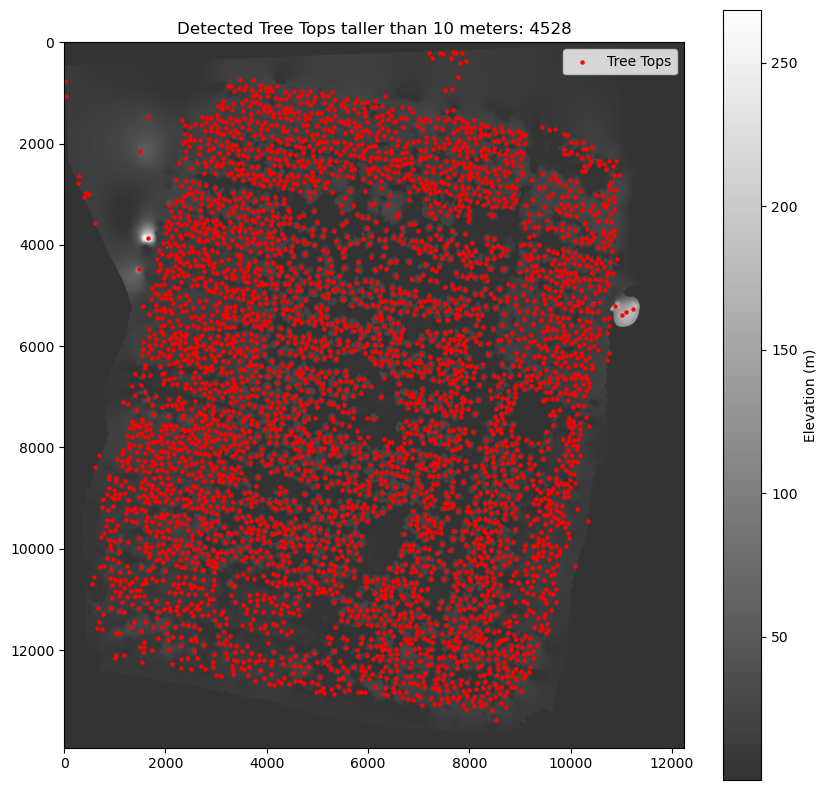

In [6]:
tree_top_values, fig, ax = detect_tree_tops(output_ndsm, neighborhood_size=100, min_height_threshold=10, sigma=2)

In [8]:
# Save the plot as a JPG
fig.savefig(r"C:\Users\lwfeckesim\Desktop\bernhard_uav_height\tree_tops_visualization.jpg", format='jpg', dpi=300, bbox_inches='tight')



In [7]:
# Convert to DataFrame
df = pd.DataFrame(tree_top_values, columns=["utm_x", "utm_y", "tree_height"])

# Save as CSV
#df.to_csv(r"C:\Users\lwfeckesim\Desktop\bernhard_uav_height\tree_tops.csv", index=False)


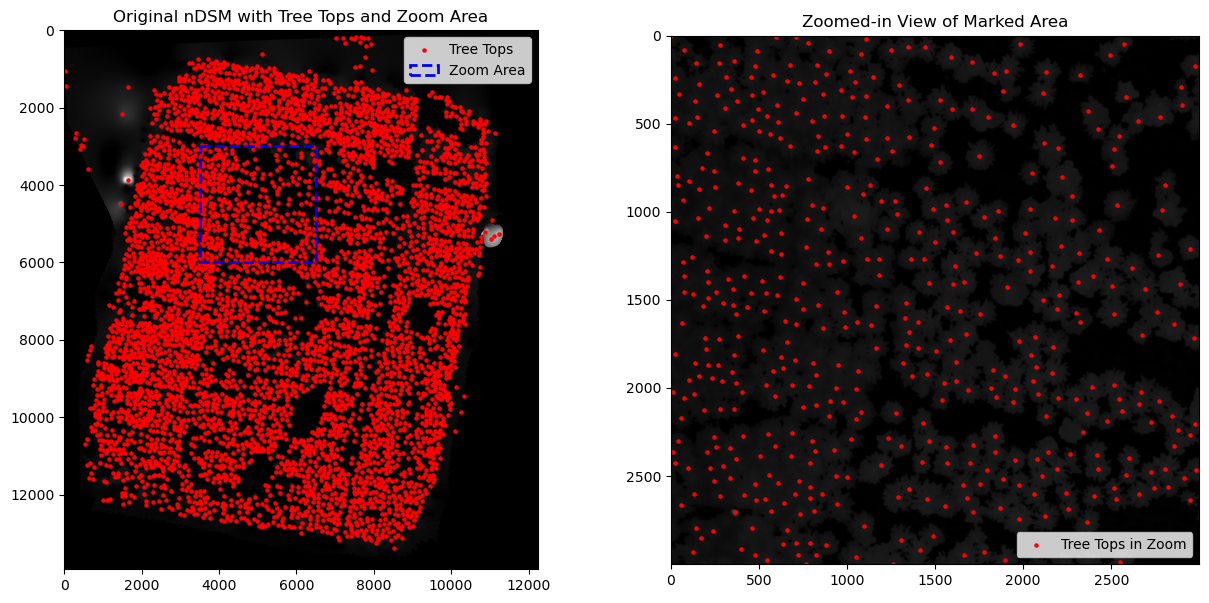

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import gaussian_filter, maximum_filter, label

# Parameters
ndsm_file = output_ndsm# Path to your nDSM raster file
neighborhood_size = 75  # Size of the neighborhood for local maxima detection (in pixels)
min_height_threshold = 10  # Minimum height of trees to be detected (in meters)
sigma = 3  # Gaussian smoothing parameter to reduce noise in the nDSM
zoom_coords = (3500, 3000)  # Top-left corner of the zoomed-in region
zoom_size = 3000  # Size of the square region to zoom in (in pixels)

# Load the nDSM raster
with rasterio.open(ndsm_file) as src:
    ndsm = src.read(1)  # Read the nDSM data

# Apply Gaussian filter to smooth the nDSM and reduce noise
smoothed_ndsm = gaussian_filter(ndsm, sigma=sigma)

# Apply a maximum filter to detect local maxima (tree tops)
local_max = maximum_filter(smoothed_ndsm, size=neighborhood_size) == smoothed_ndsm

# Apply a height threshold to only keep tree tops taller than the given height threshold
tree_tops_mask = local_max & (smoothed_ndsm > min_height_threshold)

# Label each detected tree top (connected components)
labeled_treetops, num_features = label(tree_tops_mask)

# Extract the coordinates of the detected tree tops (local row, col)
tree_top_coords = np.column_stack(np.where(labeled_treetops > 0))

# Mask negative values from the nDSM (anything below 0)
masked_ndsm = np.ma.masked_where(smoothed_ndsm < 0, smoothed_ndsm)

# Dynamically set vmin and vmax based on the valid (non-masked) data
valid_ndsm = smoothed_ndsm[smoothed_ndsm > 0]
vmin_value = np.min(valid_ndsm)
vmax_value = np.max(valid_ndsm)

# Create a custom grayscale colormap where masked values (negative) are black
cmap = plt.cm.gray
cmap.set_bad(color='black')

# Plot the original nDSM with detected tree tops
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Original nDSM with marked zoom area
ax[0].imshow(masked_ndsm, cmap=cmap, vmin=vmin_value, vmax=vmax_value)
ax[0].set_title('Original nDSM with Tree Tops and Zoom Area')
ax[0].scatter(tree_top_coords[:, 1], tree_top_coords[:, 0], color='red', marker='o', s=5, label='Tree Tops')
ax[0].add_patch(plt.Rectangle(zoom_coords, zoom_size, zoom_size, edgecolor='blue', facecolor='none', linewidth=2, linestyle='--', label='Zoom Area'))
ax[0].legend()

# Clip out the zoomed area
zoomed_ndsm = masked_ndsm[zoom_coords[0]:zoom_coords[0] + zoom_size, zoom_coords[1]:zoom_coords[1] + zoom_size]

# Display the zoomed area at a larger scale to show details
ax[1].imshow(zoomed_ndsm, cmap=cmap, vmin=vmin_value, vmax=vmax_value)
ax[1].set_title('Zoomed-in View of Marked Area')

# Only plot tree tops within the zoomed region
zoomed_tree_top_coords = tree_top_coords - [zoom_coords[0], zoom_coords[1]]
zoomed_tree_top_coords = zoomed_tree_top_coords[(zoomed_tree_top_coords[:, 0] >= 0) & (zoomed_tree_top_coords[:, 0] < zoom_size) &
                                                (zoomed_tree_top_coords[:, 1] >= 0) & (zoomed_tree_top_coords[:, 1] < zoom_size)]
ax[1].scatter(zoomed_tree_top_coords[:, 1], zoomed_tree_top_coords[:, 0], color='red', marker='o', s=5, label='Tree Tops in Zoom')
ax[1].legend()

plt.show()

# Save the plot as a JPG
fig.savefig(r"C:\Users\lwfeckesim\Desktop\bernhard_uav_height\tree_tops_and_zoom.jpg", format='jpg', dpi=300, bbox_inches='tight')


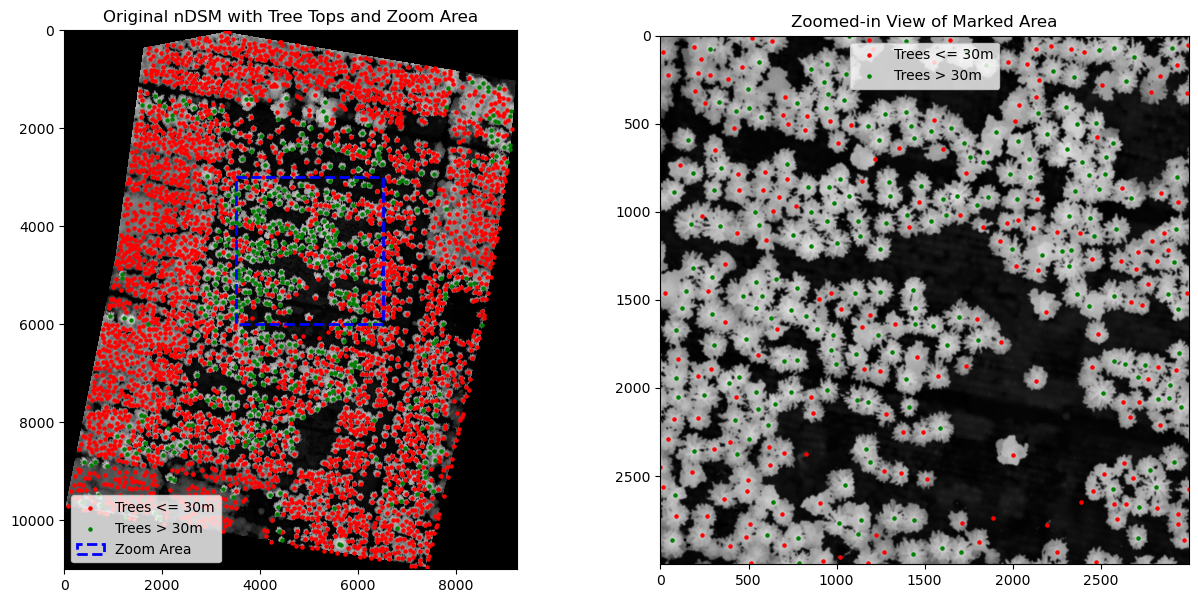

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import gaussian_filter, maximum_filter, label

# Parameters
ndsm_file = output_ndsm # Path to your nDSM raster file
neighborhood_size = 75  # Size of the neighborhood for local maxima detection (in pixels)
min_height_threshold = 10  # Minimum height of trees to be detected (in meters)
sigma = 3  # Gaussian smoothing parameter to reduce noise in the nDSM
zoom_coords = (3500, 3000)  # Top-left corner of the zoomed-in region
zoom_size = 3000  # Size of the square region to zoom in (in pixels)

# Load the nDSM raster
with rasterio.open(ndsm_file) as src:
    ndsm = src.read(1)  # Read the nDSM data

# Apply Gaussian filter to smooth the nDSM and reduce noise
smoothed_ndsm = gaussian_filter(ndsm, sigma=sigma)

# Apply a maximum filter to detect local maxima (tree tops)
local_max = maximum_filter(smoothed_ndsm, size=neighborhood_size) == smoothed_ndsm

# Apply a height threshold to only keep tree tops taller than the given height threshold
tree_tops_mask = local_max & (smoothed_ndsm > min_height_threshold)

# Label each detected tree top (connected components)
labeled_treetops, num_features = label(tree_tops_mask)

# Extract the coordinates and heights of the detected tree tops
tree_top_coords = np.column_stack(np.where(labeled_treetops > 0))
tree_heights = smoothed_ndsm[tree_top_coords[:, 0], tree_top_coords[:, 1]]

# Separate coordinates based on height
short_trees = tree_top_coords[tree_heights <= 30]
tall_trees = tree_top_coords[tree_heights > 30]

# Mask negative values from the nDSM (anything below 0)
masked_ndsm = np.ma.masked_where(smoothed_ndsm < 0, smoothed_ndsm)

# Dynamically set vmin and vmax based on the valid (non-masked) data
valid_ndsm = smoothed_ndsm[smoothed_ndsm > 0]
vmin_value = np.min(valid_ndsm)
vmax_value = np.max(valid_ndsm)

# Create a custom grayscale colormap where masked values (negative) are black
cmap = plt.cm.gray
cmap.set_bad(color='black')

# Plot the original nDSM with detected tree tops
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Original nDSM with marked zoom area
ax[0].imshow(masked_ndsm, cmap=cmap, vmin=vmin_value, vmax=vmax_value)
ax[0].set_title('Original nDSM with Tree Tops and Zoom Area')
ax[0].scatter(short_trees[:, 1], short_trees[:, 0], color='red', marker='o', s=5, label='Trees <= 30m')
ax[0].scatter(tall_trees[:, 1], tall_trees[:, 0], color='green', marker='o', s=5, label='Trees > 30m')
ax[0].add_patch(plt.Rectangle(zoom_coords, zoom_size, zoom_size, edgecolor='blue', facecolor='none', linewidth=2, linestyle='--', label='Zoom Area'))
ax[0].legend()

# Clip out the zoomed area
zoomed_ndsm = masked_ndsm[zoom_coords[0]:zoom_coords[0] + zoom_size, zoom_coords[1]:zoom_coords[1] + zoom_size]

# Display the zoomed area at a larger scale to show details
ax[1].imshow(zoomed_ndsm, cmap=cmap, vmin=vmin_value, vmax=vmax_value)
ax[1].set_title('Zoomed-in View of Marked Area')

# Only plot tree tops within the zoomed region
zoomed_short_trees = short_trees - [zoom_coords[0], zoom_coords[1]]
zoomed_tall_trees = tall_trees - [zoom_coords[0], zoom_coords[1]]

# Filter points within zoomed area
zoomed_short_trees = zoomed_short_trees[(zoomed_short_trees[:, 0] >= 0) & (zoomed_short_trees[:, 0] < zoom_size) &
                                        (zoomed_short_trees[:, 1] >= 0) & (zoomed_short_trees[:, 1] < zoom_size)]
zoomed_tall_trees = zoomed_tall_trees[(zoomed_tall_trees[:, 0] >= 0) & (zoomed_tall_trees[:, 0] < zoom_size) &
                                      (zoomed_tall_trees[:, 1] >= 0) & (zoomed_tall_trees[:, 1] < zoom_size)]

# Plot the tree tops in the zoomed-in view
ax[1].scatter(zoomed_short_trees[:, 1], zoomed_short_trees[:, 0], color='red', marker='o', s=5, label='Trees <= 30m')
ax[1].scatter(zoomed_tall_trees[:, 1], zoomed_tall_trees[:, 0], color='green', marker='o', s=5, label='Trees > 30m')
ax[1].legend()

plt.show()

# Save the plot as a JPG
#fig.savefig(r"C:\Users\lwfeckesim\Desktop\bernhard_uav_height\tree_tops_and_zoom.jpg", format='jpg', dpi=300, bbox_inches='tight')


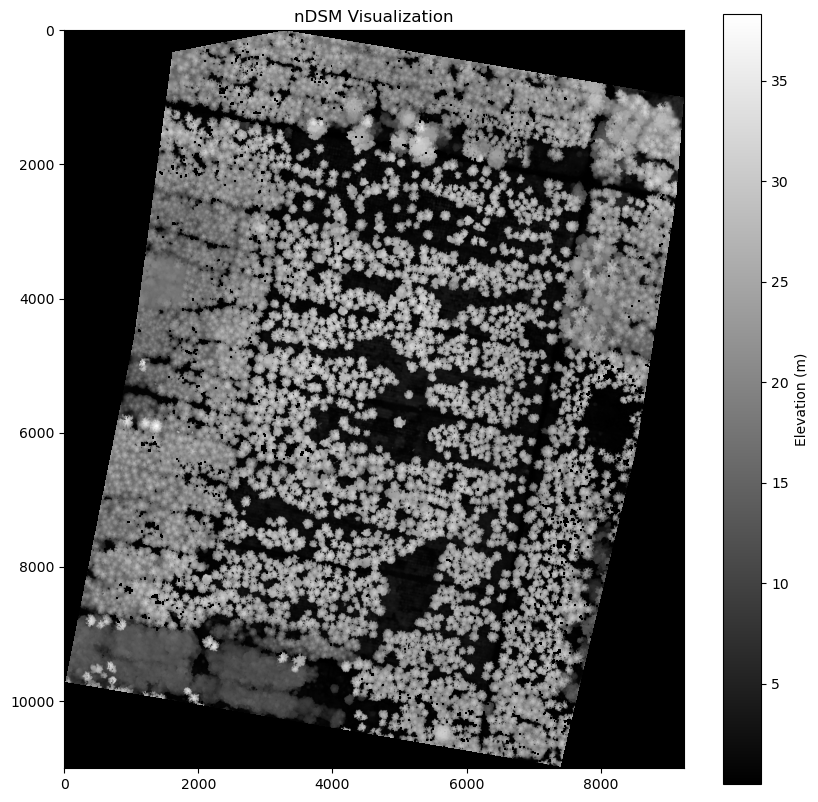

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import gaussian_filter

# Parameters
ndsm_file = output_ndsm  # Replace with the correct path
# sigma = 2  # Gaussian smoothing parameter to reduce noise in the nDSM (optional)

# Load the nDSM raster
with rasterio.open(ndsm_file) as src:
    ndsm = src.read(1)  # Read the nDSM data

# Apply Gaussian filter to smooth the nDSM and reduce noise (optional)
# smoothed_ndsm = gaussian_filter(ndsm, sigma=sigma)

# Mask negative values from the nDSM (anything below 0)
masked_ndsm = np.ma.masked_where(ndsm < 0, ndsm)

# Dynamically set vmin and vmax based on the valid (non-masked) data
valid_ndsm = ndsm[ndsm > 0]
vmin_value = np.min(valid_ndsm)
vmax_value = np.max(valid_ndsm)

# Create a custom grayscale colormap where masked values (negative) are black
cmap = plt.cm.gray
cmap.set_bad(color='black')

# Plot the nDSM and save the figure
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(masked_ndsm, cmap=cmap, vmin=vmin_value, vmax=vmax_value)
ax.set_title('nDSM Visualization')
cbar = fig.colorbar(img, ax=ax, label='Elevation (m)')

# Show the plot
plt.show()

# Save the plot as a JPG
fig.savefig(r"C:\Users\lwfeckesim\Desktop\bernhard_uav_height\ndsm.jpg", format='jpg', dpi=300, bbox_inches='tight')


In [9]:
# Connection parameters
dsn_name = "ecke"  # Replace with your DSN name

# Establish the connection
try:
    conn = pyodbc.connect(f"DSN={dsn_name};")
    print("Connected to the database successfully.")

    # Create a cursor object
    cursor = conn.cursor()

    # Query to list all columns for all tables
    query = """
    SELECT TABLE_SCHEMA, TABLE_NAME, COLUMN_NAME, DATA_TYPE
    FROM INFORMATION_SCHEMA.COLUMNS
    ORDER BY TABLE_SCHEMA, TABLE_NAME, ORDINAL_POSITION;
    """

    # Execute the query
    cursor.execute(query)

    # Fetch all results
    columns = cursor.fetchall()

    # Print results
    print("Columns in Database:")
    current_table = None
    for row in columns:
        if current_table != f"{row.TABLE_SCHEMA}.{row.TABLE_NAME}":
            current_table = f"{row.TABLE_SCHEMA}.{row.TABLE_NAME}"
            print(f"\nTable: {current_table}")
        print(f"  - {row.COLUMN_NAME} ({row.DATA_TYPE})")

    # Close the connection
    cursor.close()
    conn.close()
    print("Connection closed.")

except Exception as e:
    print(f"An error occurred: {e}")


Connected to the database successfully.
Columns in Database:

Table: dbo.__xxProbekreisBaum
  - ForsteinrichtungsPeriode (tinyint)
  - BestandesSchluessel (float)
  - BestandesTeilflaeche (tinyint)
  - Koordinaten (int)
  - Satznummer (smallint)
  - BHDStufe (smallint)
  - Baumartenschluessel (tinyint)
  - BHD (real)
  - Stammzahl (real)
  - Hoehe (real)
  - PolarkoordinatenWinkel (smallint)
  - PolarkoordinatenEntfernung (smallint)
  - Hoehenmessbaum (nvarchar)
  - Mortalitaetskennzeichen (tinyint)
  - AnzahlBaeume (smallint)

Table: dbo.__zzProbekreis
  - ForsteinrichtungsPeriode (tinyint)
  - BestandesSchluessel (float)
  - BestandesTeilflaeche (tinyint)
  - Koordinaten (int)
  - Repraesentationsflaeche (real)
  - Aufnahmemethode (tinyint)
  - Standortseinheit1 (tinyint)
  - Standortseinheit2 (tinyint)
  - Standortseinheit3 (tinyint)
  - Standortsmerkmale (tinyint)
  - StandortseinheitHochgebirge (tinyint)
  - Standortseinheitengruppe (tinyint)
  - GaussKruegerRechtswert (int)
  - G

In [10]:
dsn_name = "ecke"  # Replace with your DSN name

try:
    conn = pyodbc.connect(f"DSN={dsn_name};")
    print("Connected to the database successfully.")

    with conn.cursor() as cursor:
        query = """
        SELECT * FROM dbo.Objekte
        WHERE Versuch = ?
        AND Parzelle = ?
        """
        cursor.execute(query, (151, 1))

        # Fetch column names
        column_names = [column[0] for column in cursor.description]
        print("Column Names:")
        print(", ".join(column_names))  # Print column names once

        # Fetch all results
        results = cursor.fetchall()

        # Print each row of data
        print("\nData:")
        for row in results:
            print(row)

    print("Connection closed.")

except Exception as e:
    print(f"An error occurred: {e}")


Connected to the database successfully.
Column Names:
Versuch, Parzelle, ObjektTyp, Nr, Artcode, OriginalNummer, x, y, z, xOriginal, yOriginal, zOriginal, Einmessung, IndexOderMetrisch, RasterGroesse, RadiusProbeKreis, ReihenNummer, Gruppe, xcrewho, xcrewhen, xlogwho, xlogwhen, UTM_x, UTM_y, UTM_z, Genauigkeit

Data:
(151, 1, 'Baum', 1, 70, None, 1.0, 0.5, None, None, None, None, 'Errechnet aus Pflanzverband', None, None, None, None, None, 'ADS\\ge73yos', datetime.datetime(2022, 1, 21, 14, 30, 37, 317000), 'ADS\\ge73yos', datetime.datetime(2022, 1, 21, 14, 30, 37, 317000), None, None, None, None)
(151, 1, 'Baum', 2, 70, None, 1.0, 1.5, None, None, None, None, 'Errechnet aus Pflanzverband', None, None, None, None, None, 'ADS\\ge73yos', datetime.datetime(2022, 1, 21, 14, 30, 37, 317000), 'ADS\\ge73yos', datetime.datetime(2022, 1, 21, 14, 30, 37, 317000), None, None, None, None)
(151, 1, 'Baum', 3, 70, None, 1.0, 2.5, None, None, None, None, 'Errechnet aus Pflanzverband', None, None, None

In [11]:
dsn_name = "ecke"  # Replace with your DSN name

try:
    conn = pyodbc.connect(f"DSN={dsn_name};")
    print("Connected to the database successfully.")

    with conn.cursor() as cursor:
        # Query to count unique Parzelle values per Versuch
        query = """
        SELECT Versuch, COUNT(DISTINCT Parzelle) AS ParzelleCount
        FROM dbo.Objekte
        GROUP BY Versuch
        ORDER BY Versuch;
        """
        cursor.execute(query)

        # Fetch column names
        column_names = [column[0] for column in cursor.description]
        print("Column Names:")
        print(", ".join(column_names))

        # Fetch and print results
        print("\nData:")
        results = cursor.fetchall()
        for row in results:
            print(row)

    print("Connection closed.")

except Exception as e:
    print(f"An error occurred: {e}")


Connected to the database successfully.
Column Names:
Versuch, ParzelleCount

Data:
(2, 3)
(3, 3)
(5, 3)
(8, 3)
(9, 1)
(15, 4)
(25, 3)
(26, 3)
(27, 3)
(39, 1)
(47, 2)
(49, 1)
(50, 3)
(51, 1)
(52, 2)
(53, 2)
(56, 1)
(57, 1)
(58, 2)
(59, 1)
(60, 1)
(62, 1)
(63, 1)
(66, 2)
(67, 3)
(68, 3)
(72, 3)
(73, 3)
(79, 2)
(84, 2)
(85, 2)
(86, 2)
(88, 6)
(90, 3)
(91, 5)
(95, 18)
(97, 4)
(99, 2)
(101, 3)
(102, 3)
(105, 3)
(106, 3)
(107, 1)
(108, 2)
(110, 6)
(111, 8)
(113, 2)
(114, 1)
(115, 5)
(116, 1)
(117, 2)
(120, 4)
(121, 4)
(122, 4)
(123, 3)
(124, 2)
(125, 3)
(126, 2)
(128, 3)
(129, 6)
(130, 4)
(131, 2)
(132, 3)
(133, 8)
(134, 5)
(135, 5)
(136, 2)
(137, 2)
(138, 2)
(140, 2)
(145, 2)
(146, 6)
(147, 6)
(151, 36)
(152, 45)
(153, 45)
(154, 45)
(155, 45)
(156, 45)
(157, 45)
(209, 13)
(210, 24)
(219, 6)
(222, 12)
(225, 6)
(226, 6)
(227, 6)
(228, 6)
(229, 13)
(230, 6)
(231, 6)
(232, 6)
(233, 6)
(234, 12)
(235, 12)
(238, 6)
(239, 15)
(240, 6)
(241, 9)
(243, 9)
(256, 21)
(257, 10)
(259, 4)
(261, 4)
(262, 

In [12]:
# Example usage
dsn_name = "ecke"  # Replace with your DSN name
versuch_id = 151   # Specify the Versuch ID

corners, trees = fetch_corners_and_trees(dsn_name, versuch_id)

Connected to the database successfully.
Data retrieved successfully.
Corner points retrieved: 144
Tree points retrieved: 1547


In [7]:
# Find ground lines for all Parzellen
ground_lines = find_ground_lines(corners)

# Output
#for parzelle, (lower_left, lower_right) in ground_lines.items():
#    print(f"Parzelle {parzelle}:")
#    print(f"  Lower Left (UTM): {lower_left}")
#    print(f"  Lower Right (UTM): {lower_right}")

In [5]:
# Compute the ground vector and perpendicular vector for all Parzellen
ground_vectors = {}
perpendicular_vectors = {}

for parzelle, (utm_lower_left, utm_lower_right) in ground_lines.items():
    # Compute the ground vector for the current Parzelle
    ground_vector = np.array([utm_lower_right[0] - utm_lower_left[0], utm_lower_right[1] - utm_lower_left[1]])
    ground_length = np.linalg.norm(ground_vector)
    unit_ground_vector = ground_vector / ground_length

    # Compute the perpendicular vector for the current Parzelle
    perpendicular_vector = np.array([-unit_ground_vector[1], unit_ground_vector[0]])

    # Store the results in dictionaries
    ground_vectors[parzelle] = unit_ground_vector
    perpendicular_vectors[parzelle] = perpendicular_vector


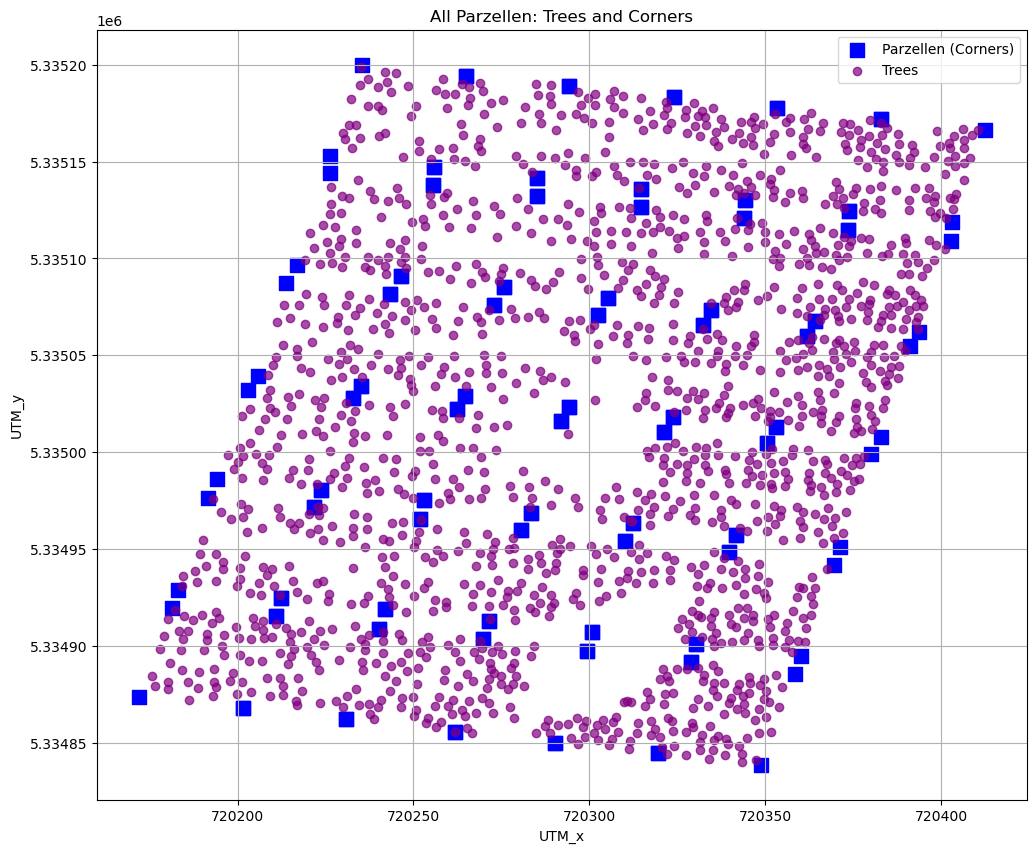

In [6]:
# Find ground lines
ground_lines = find_ground_lines(corners)

# Transform trees
transformed_trees = transform_trees_all(trees, ground_lines)

# Visualize all Parzellen
visualize_all_parzellen(corners, transformed_trees)


In [8]:
# Example: Transforming tree coordinates for all Parzellen
transformed_trees = transform_trees(trees, ground_lines, ground_vectors, perpendicular_vectors)

# Output the transformed tree coordinates
for tree in transformed_trees:
    print(tree)


(1, 1001, array([ 720343.22846487, 5334833.24546487]), array([ 720359.60333312, 5334886.87933312]))
(1, 1002, array([ 720347.44995551, 5334837.46695551]), array([ 720360.78189804, 5334888.05789804]))
(1, 1003, array([ 720343.32571552, 5334833.34271552]), array([ 720364.07441158, 5334891.35041158]))
(1, 1004, array([ 720344.73167285, 5334834.74867284]), array([ 720371.95243697, 5334899.22843697]))
(1, 1005, array([ 720348.17579891, 5334838.19279891]), array([ 720374.82088499, 5334902.09688499]))
(1, 1006, array([ 720351.49120453, 5334841.50820453]), array([ 720375.06189446, 5334902.33789446]))
(1, 1007, array([ 720347.08590677, 5334837.10290677]), array([ 720381.47386372, 5334908.74986372]))
(1, 1008, array([ 720350.171749, 5334840.188749]), array([ 720383.08866482, 5334910.36466482]))
(1, 1009, array([ 720348.14931464, 5334838.16631464]), array([ 720387.17642253, 5334914.45242253]))
(1, 1010, array([ 720353.86045027, 5334843.87745027]), array([ 720388.1526051, 5334915.4286051]))
(1, 10

(34, 1008, array([ 720346.59252652, 5335132.63452652]), array([ 720381.58365049, 5335205.84265049]))
(34, 1009, array([ 720343.68256687, 5335129.72456687]), array([ 720382.34004663, 5335206.59904663]))
(34, 1010, array([ 720345.94500853, 5335131.98700853]), array([ 720385.67641638, 5335209.93541638]))
(34, 1011, array([ 720346.93910653, 5335132.98110653]), array([ 720390.37341135, 5335214.63241135]))
(34, 1012, array([ 720349.29590126, 5335135.33790126]), array([ 720392.06323772, 5335216.32223772]))
(34, 1013, array([ 720346.06762503, 5335132.10962503]), array([ 720393.28726156, 5335217.54626156]))
(34, 1014, array([ 720346.90359897, 5335132.94559897]), array([ 720396.08031261, 5335220.33931261]))
(34, 1015, array([ 720334.99650957, 5335121.03850957]), array([ 720400.3781272, 5335224.6371272]))
(34, 1016, array([ 720337.4595768, 5335123.5015768]), array([ 720395.12614961, 5335219.38514961]))
(34, 1017, array([ 720343.18617784, 5335129.22817784]), array([ 720393.12214281, 5335217.381142

In [9]:
def visualize_all_parzellen(corner_points, tree_points):
    """
    Visualizes the corner points in blue and tree points in purple for all Parzellen.

    Args:
        corner_points (list of tuples): [(Parzelle, Nr, UTM_x, UTM_y), ...]
        tree_points (list of tuples): [(Parzelle, Nr, UTM_x, UTM_y), ...]
    """
    # Identify unique Parzellen in the dataset
    parzellen = set(p[0] for p in corner_points)

    # Create a separate plot for each Parzelle
    for parzelle in sorted(parzellen):
        plt.figure(figsize=(10, 8))

        # Filter corner points and tree points for the current Parzelle
        corners_current = [p for p in corner_points if p[0] == parzelle]
        trees_current = [t for t in tree_points if t[0] == parzelle]

        # Plot corners
        corner_x = [p[2] for p in corners_current]
        corner_y = [p[3] for p in corners_current]
        plt.scatter(corner_x, corner_y, color="blue", label="Corners")
        for i, (px, py) in enumerate(zip(corner_x, corner_y)):
            plt.text(px, py, f"Corner {i+1}", fontsize=9, color="blue")

        # Plot trees
        tree_x = [t[2] for t in trees_current]
        tree_y = [t[3] for t in trees_current]
        plt.scatter(tree_x, tree_y, color="purple", label="Trees")

        # Labels, legend, and title
        plt.xlabel("UTM_x")
        plt.ylabel("UTM_y")
        plt.title(f"Trees and Corners in UTM Coordinates (Parzelle {parzelle})")
        plt.legend()
        plt.grid(True)

        # Show the plot for the current Parzelle
        plt.show()


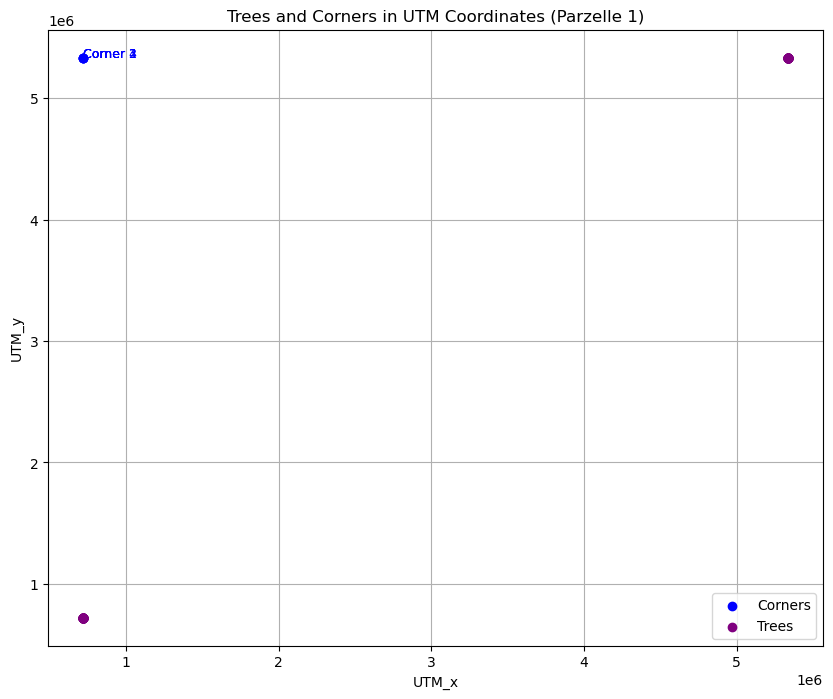

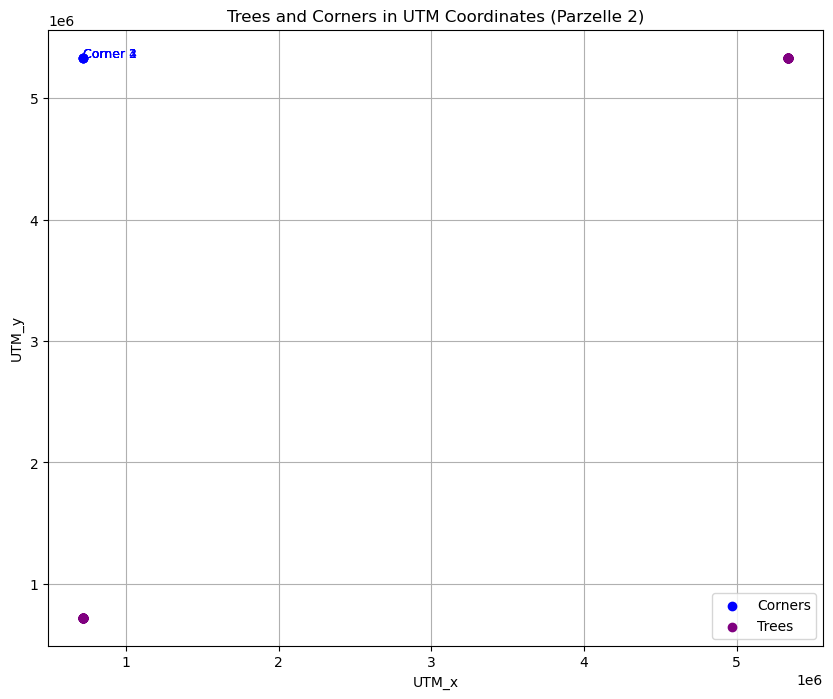

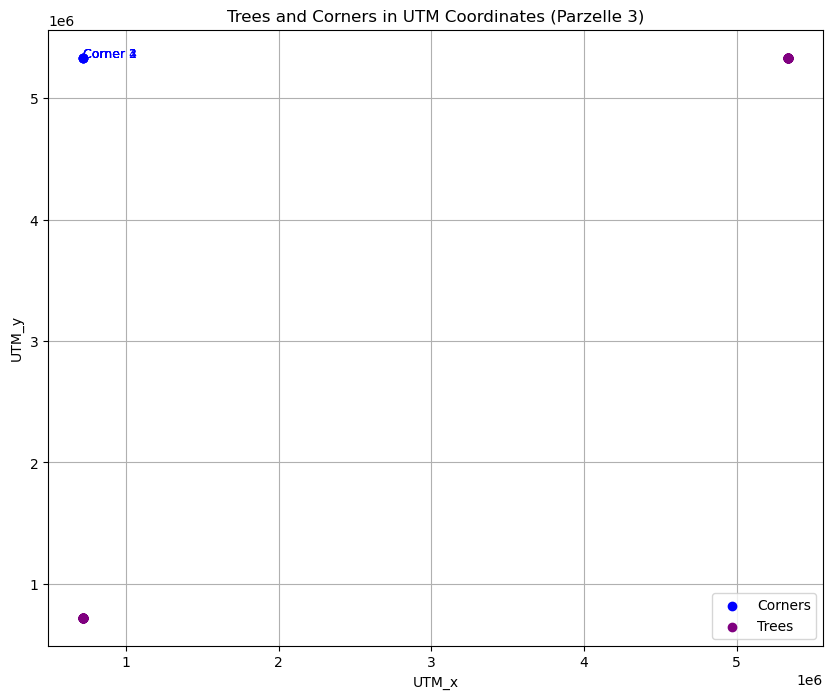

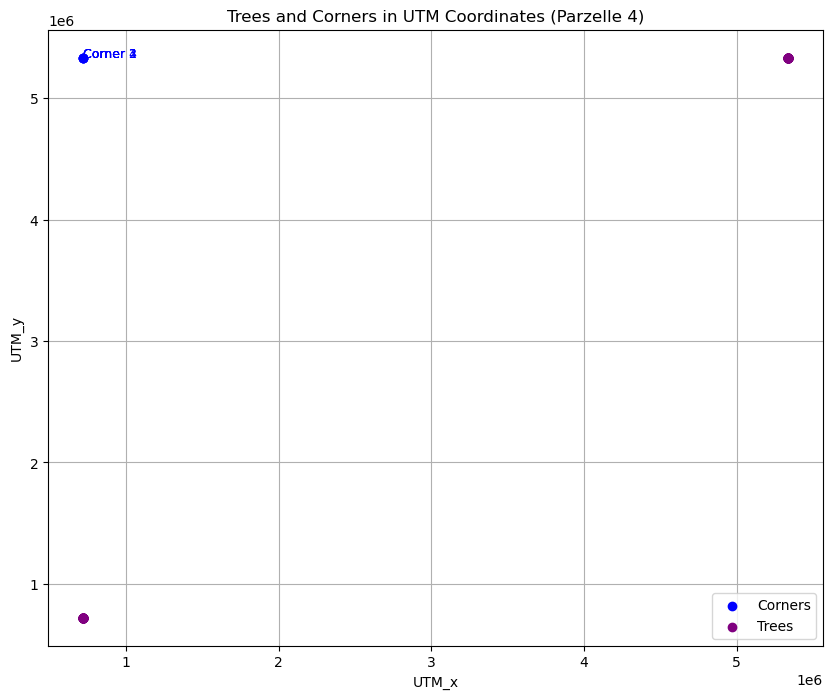

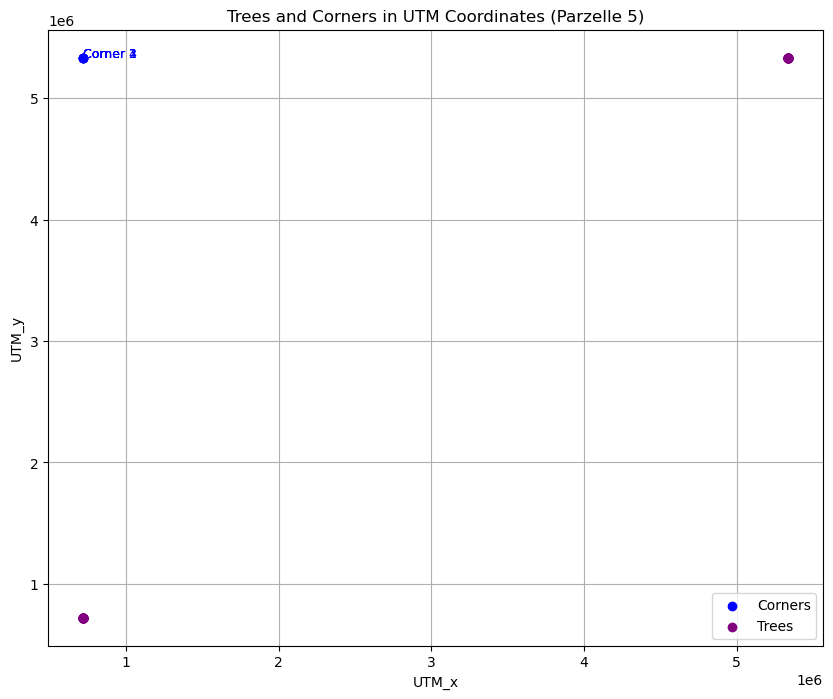

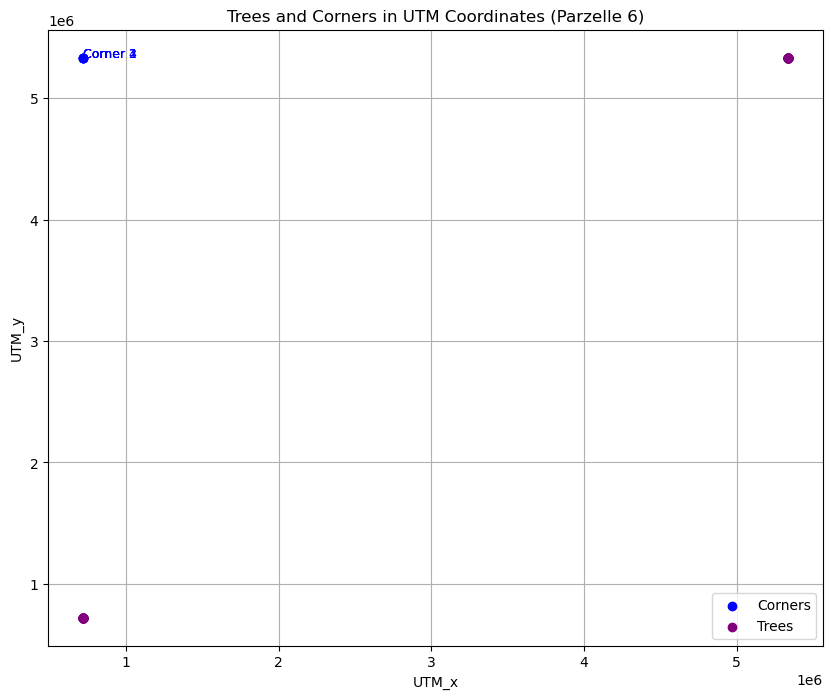

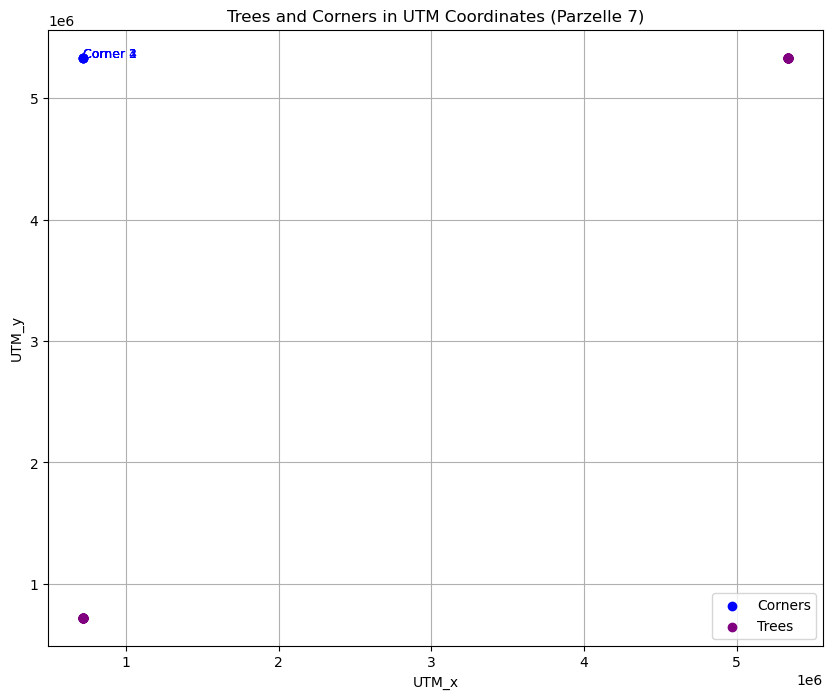

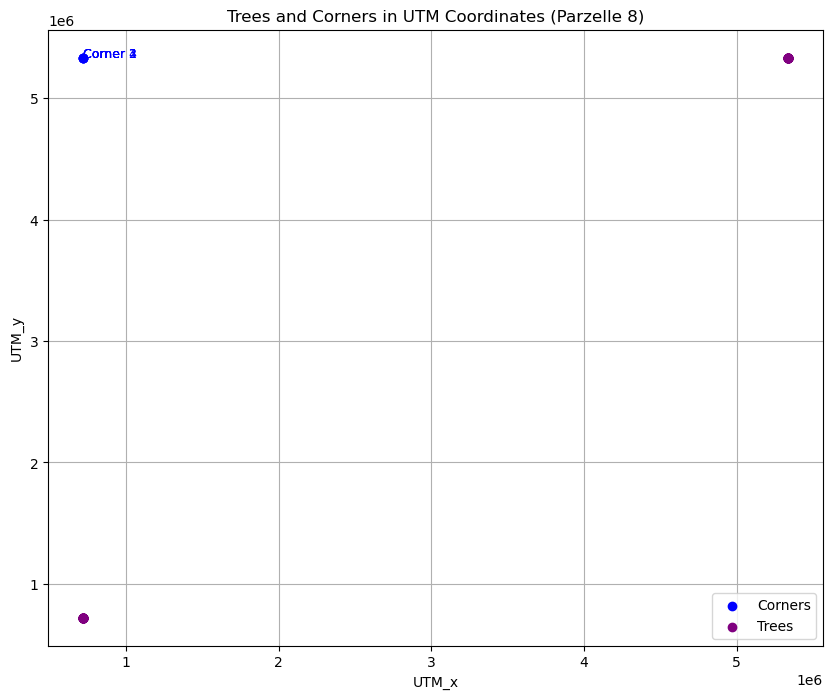

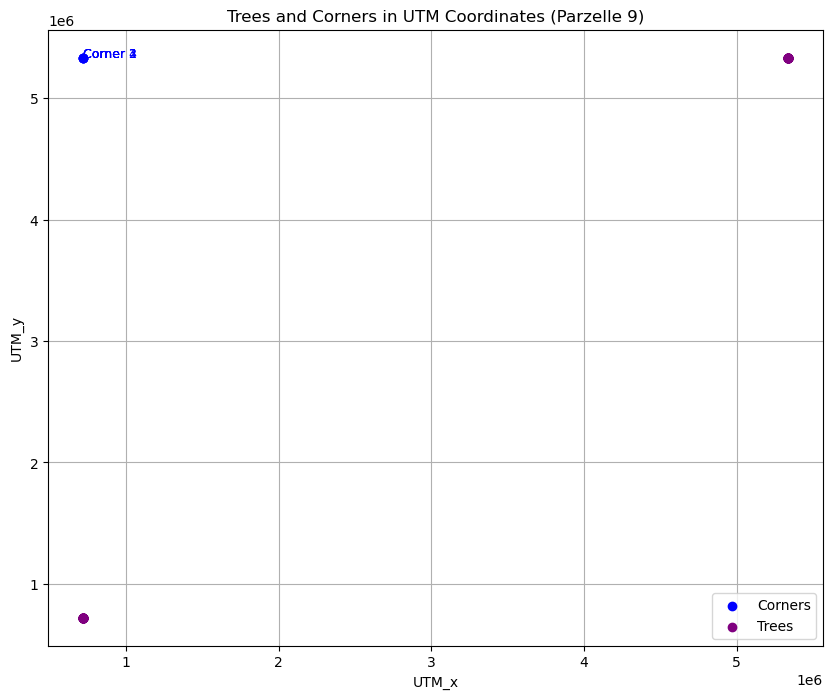

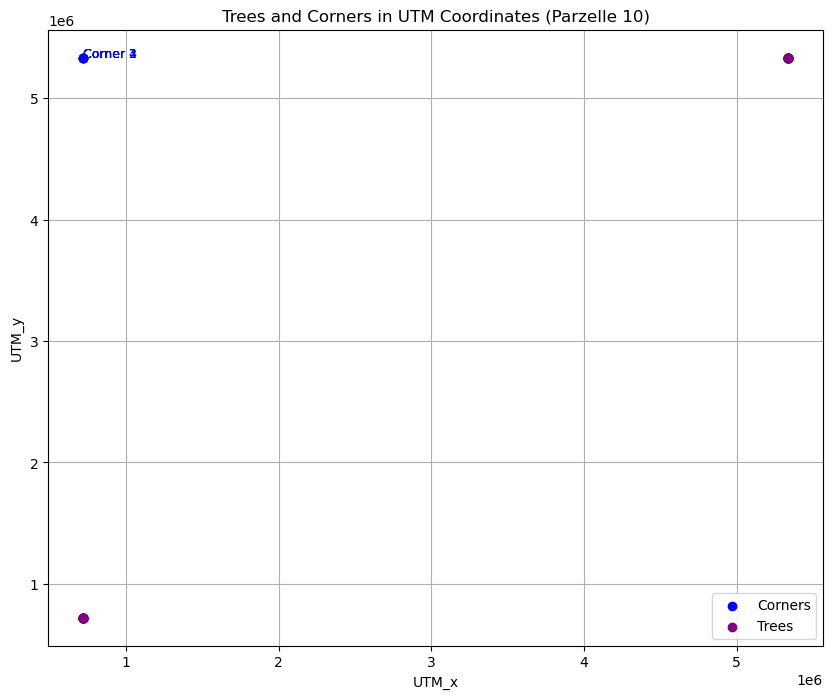

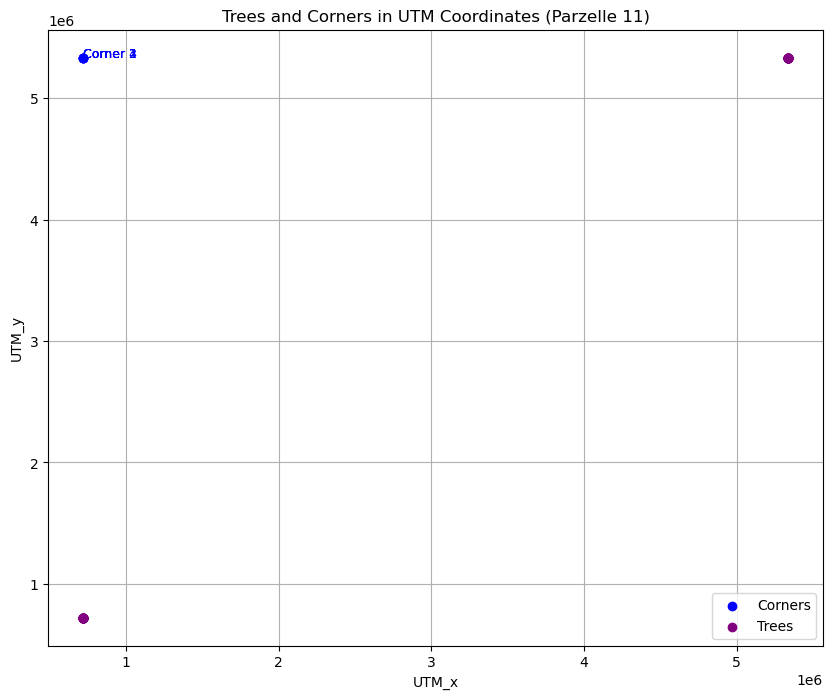

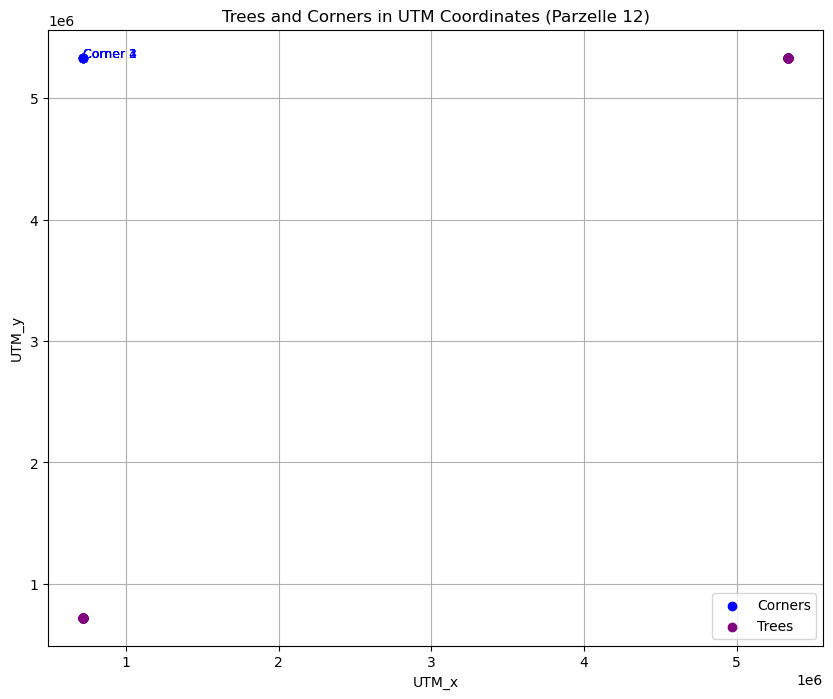

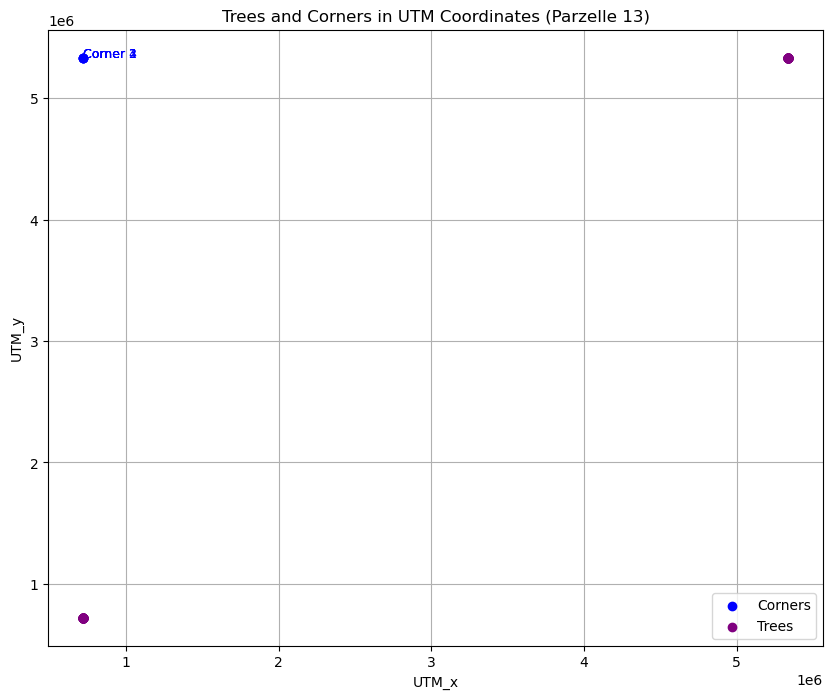

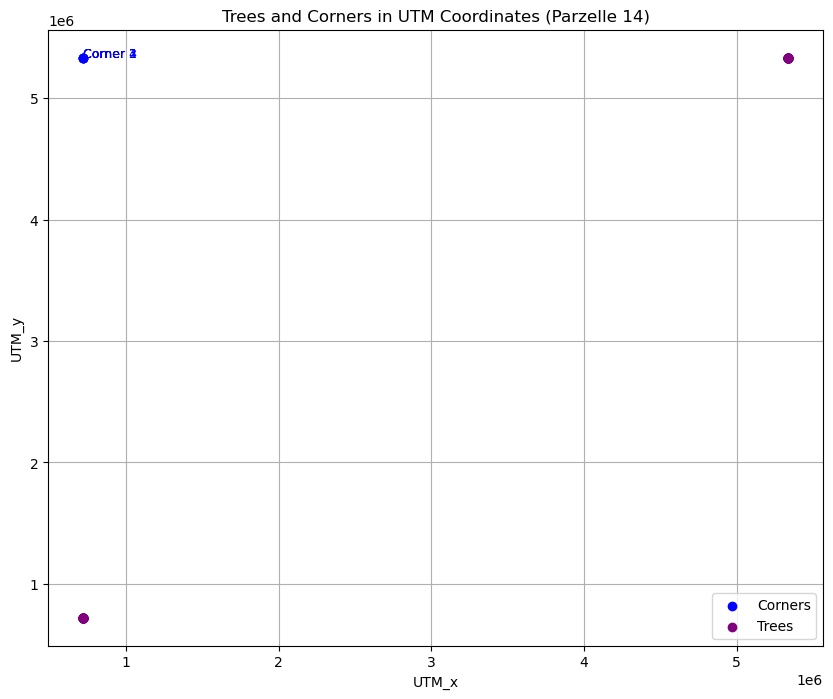

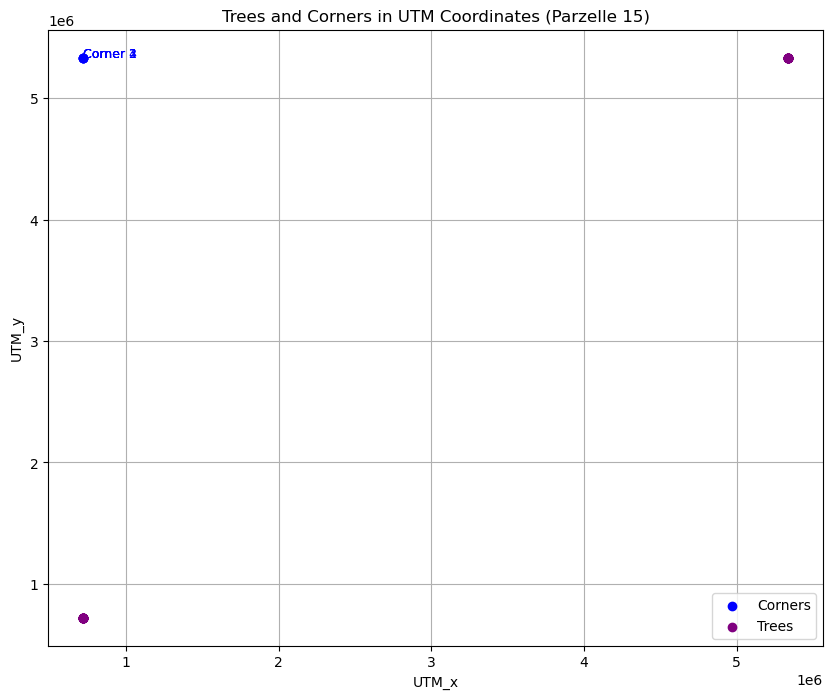

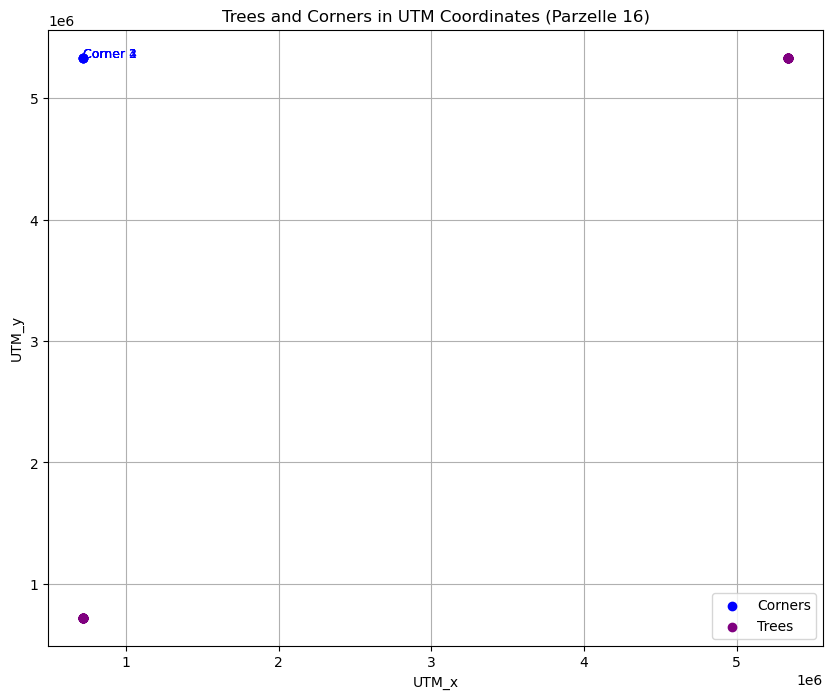

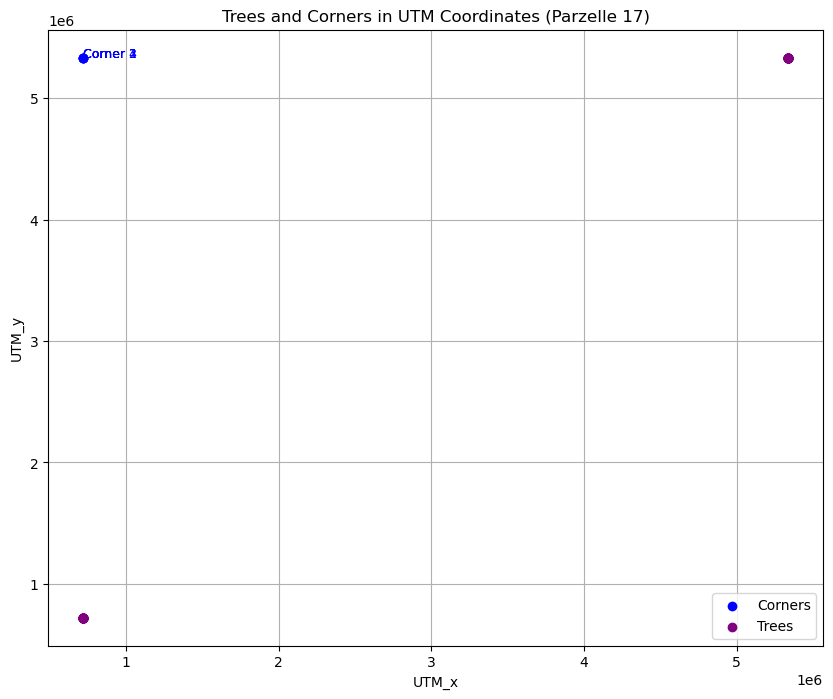

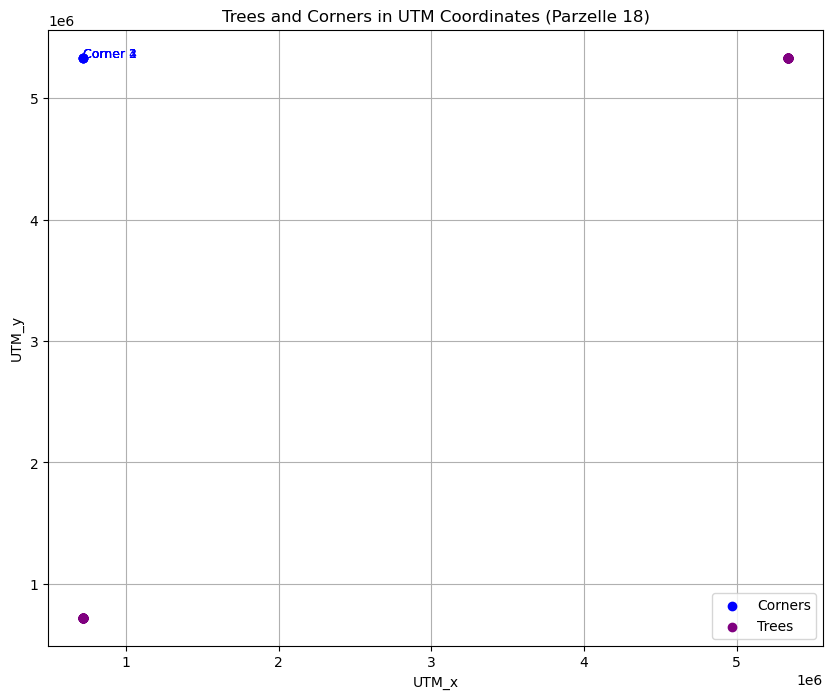

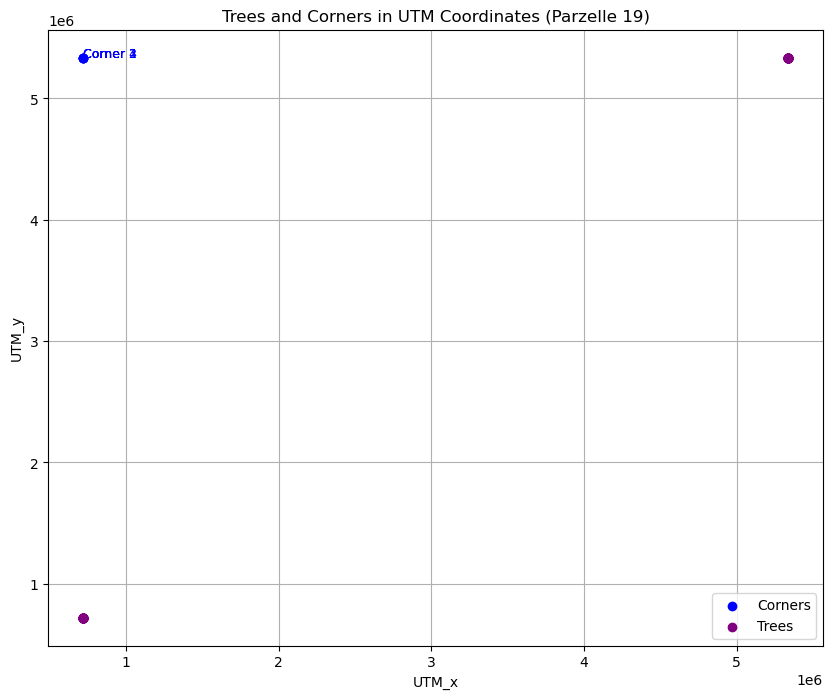

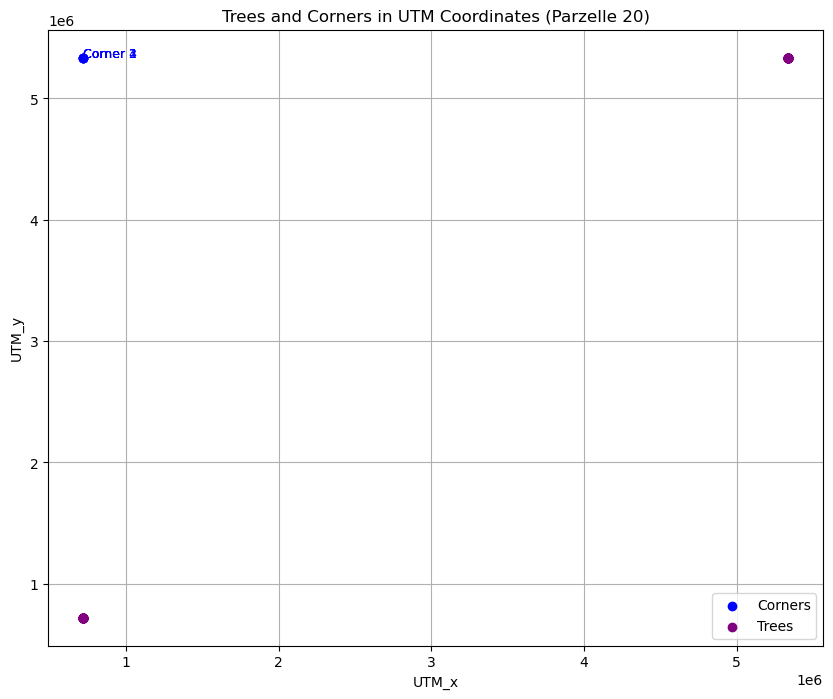

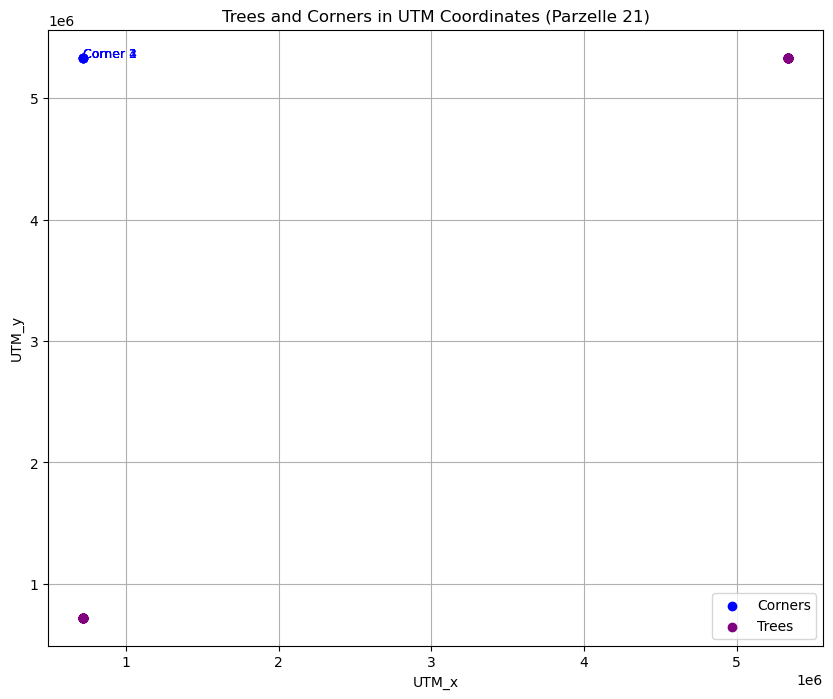

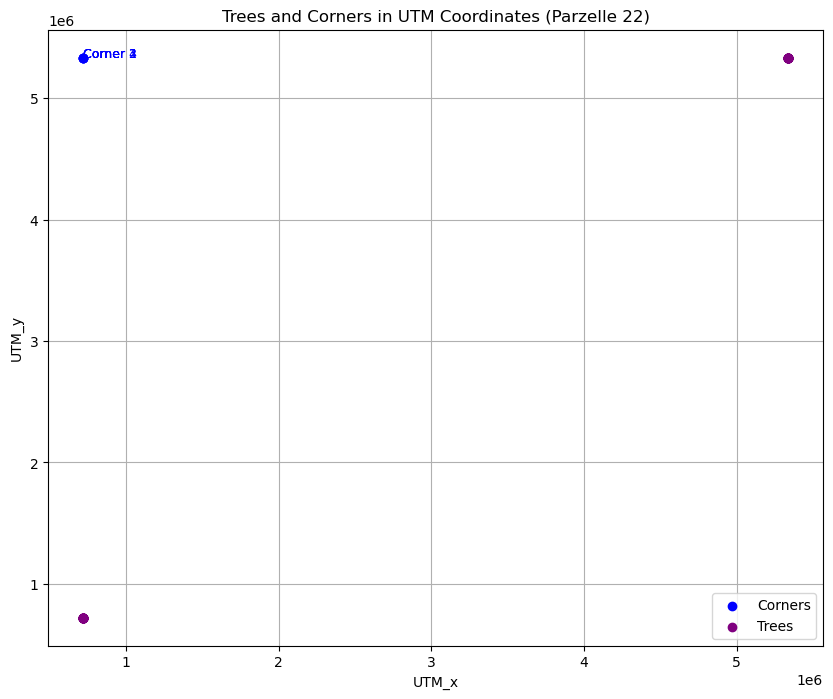

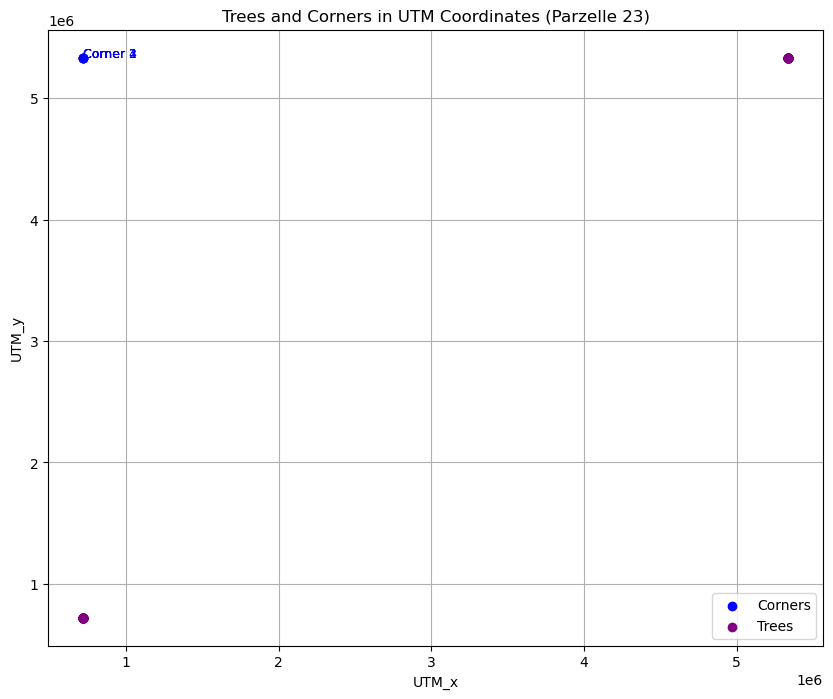

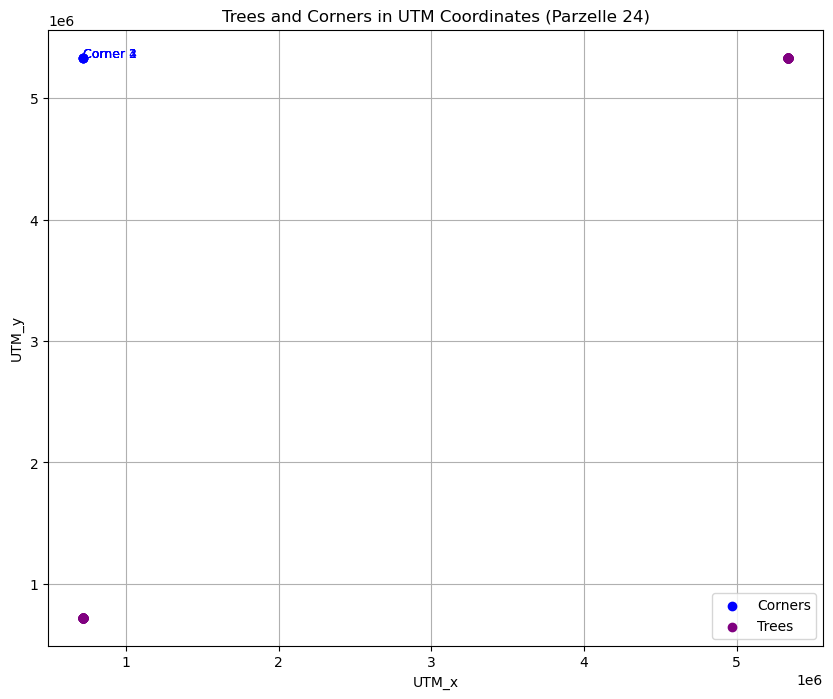

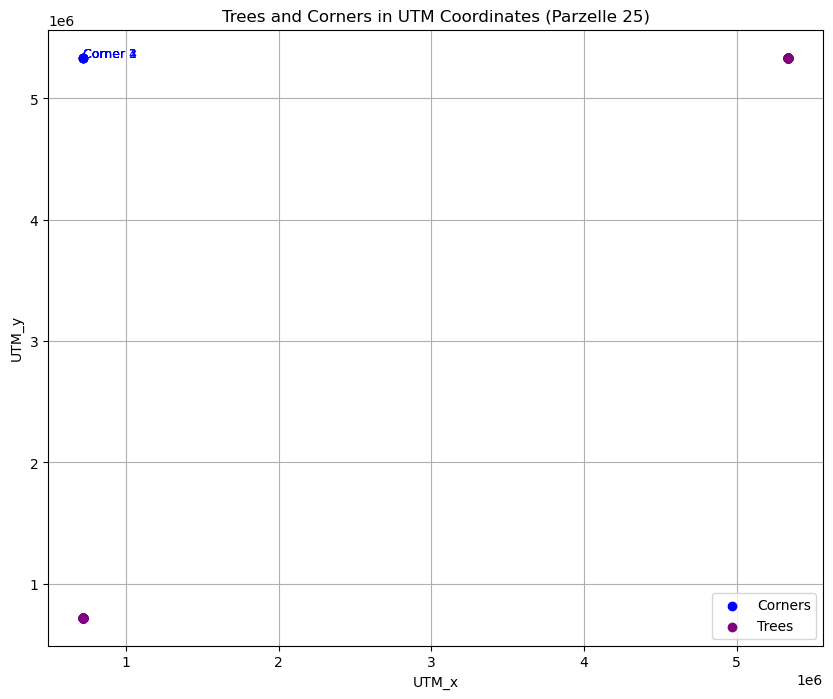

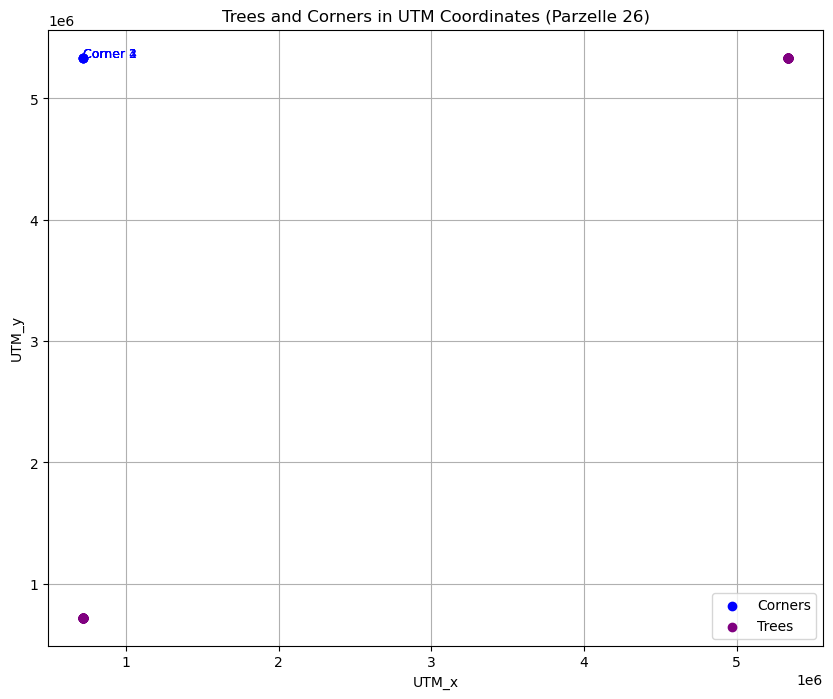

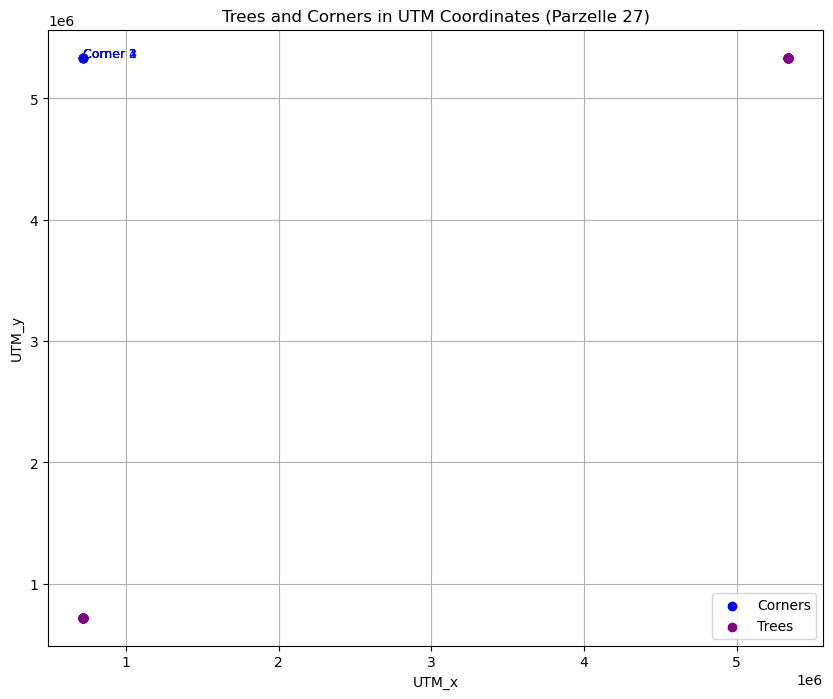

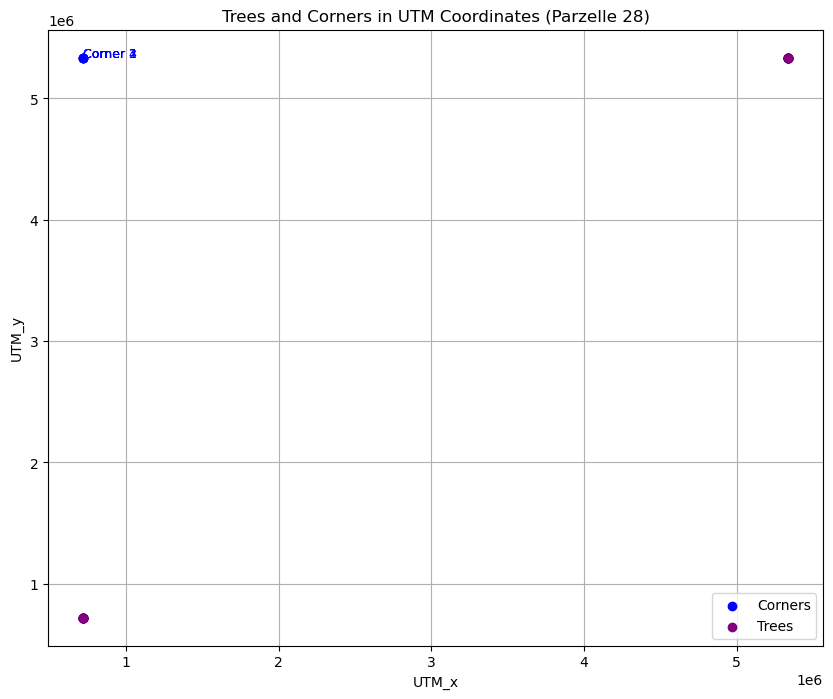

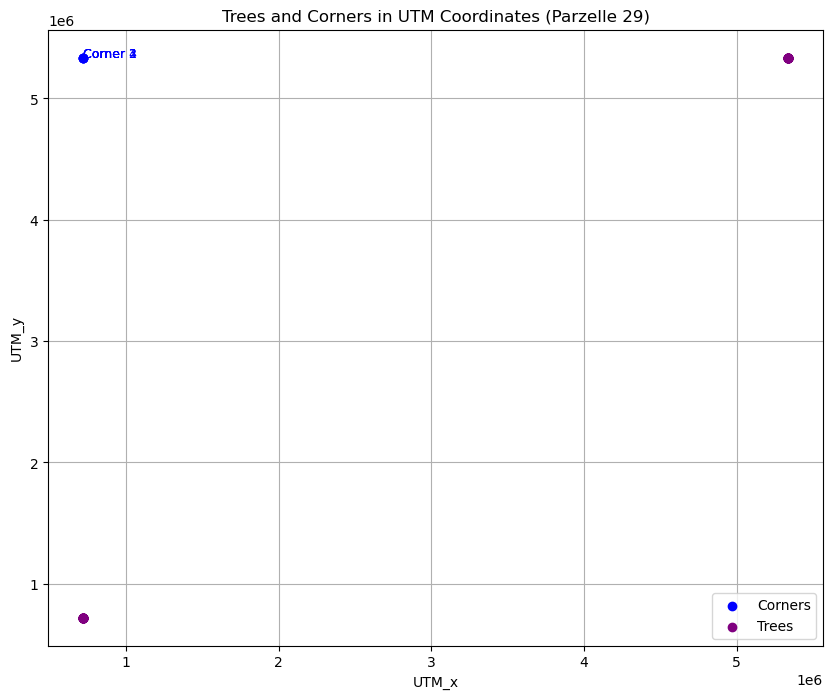

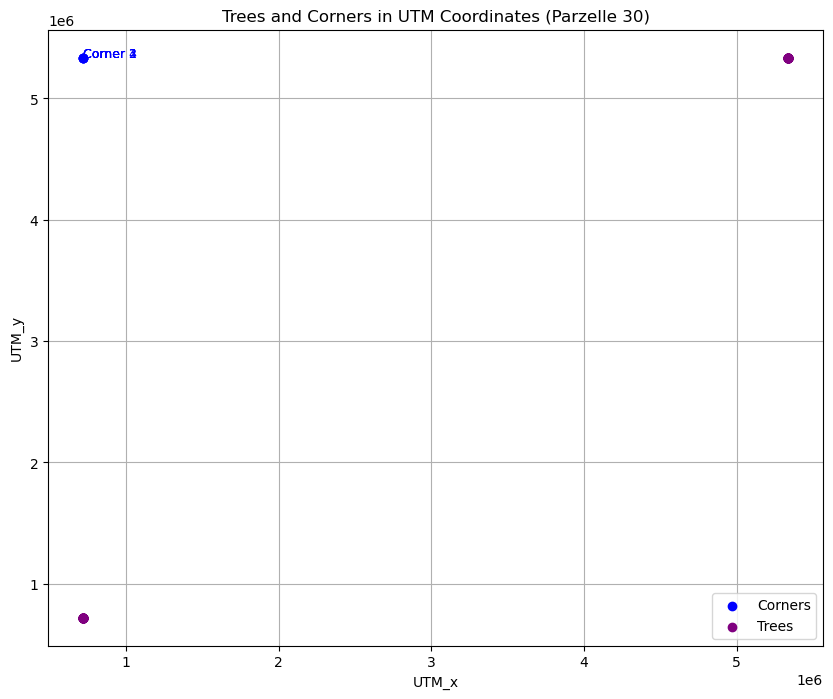

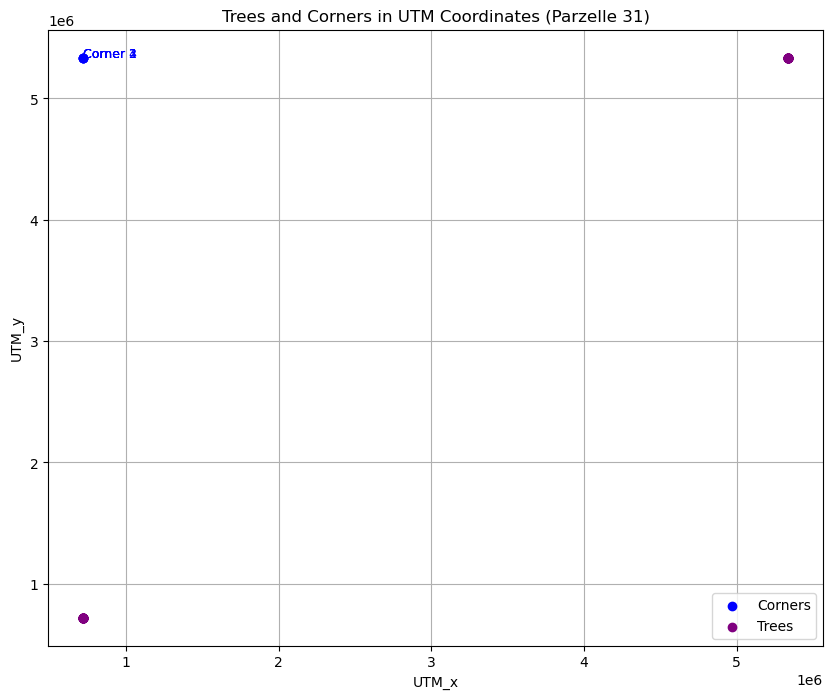

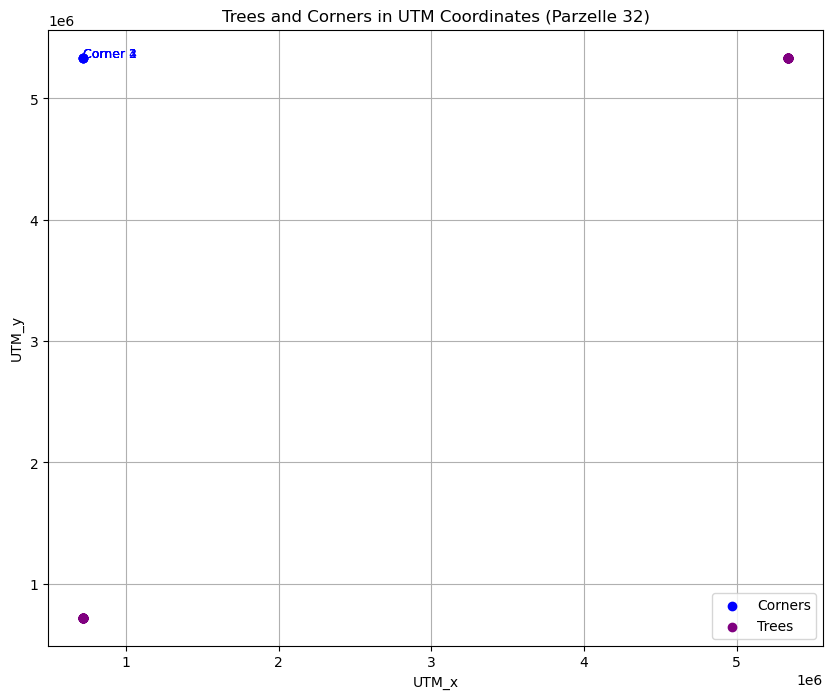

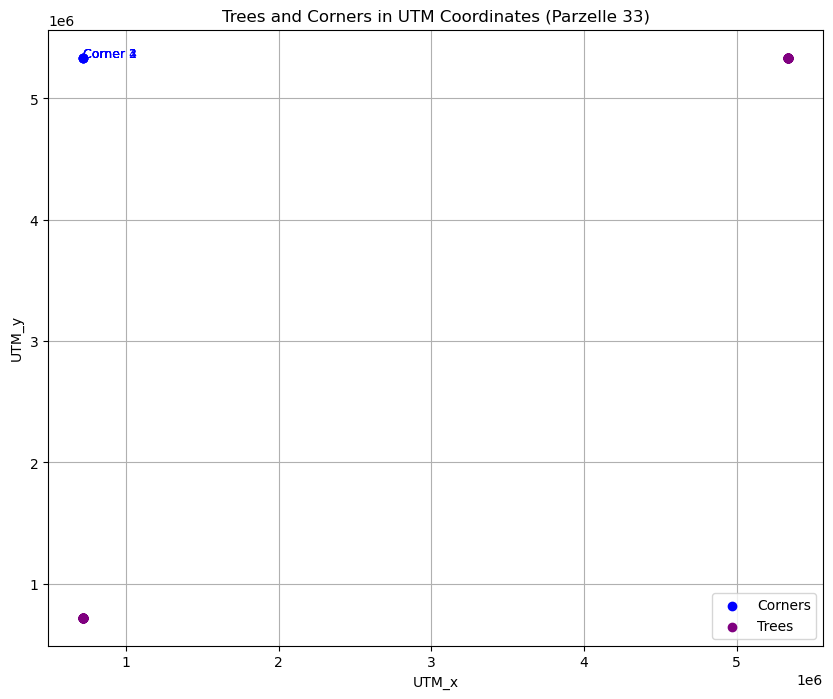

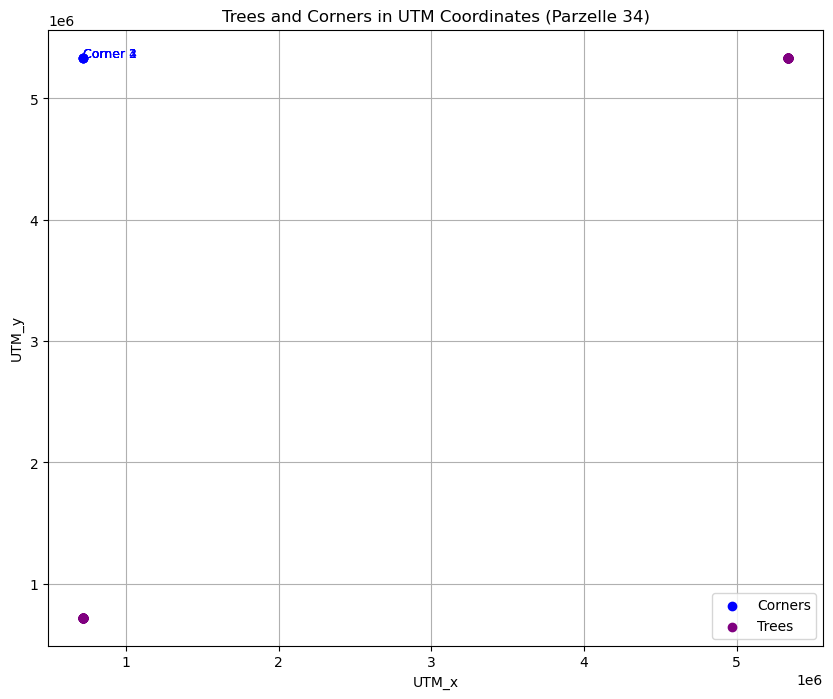

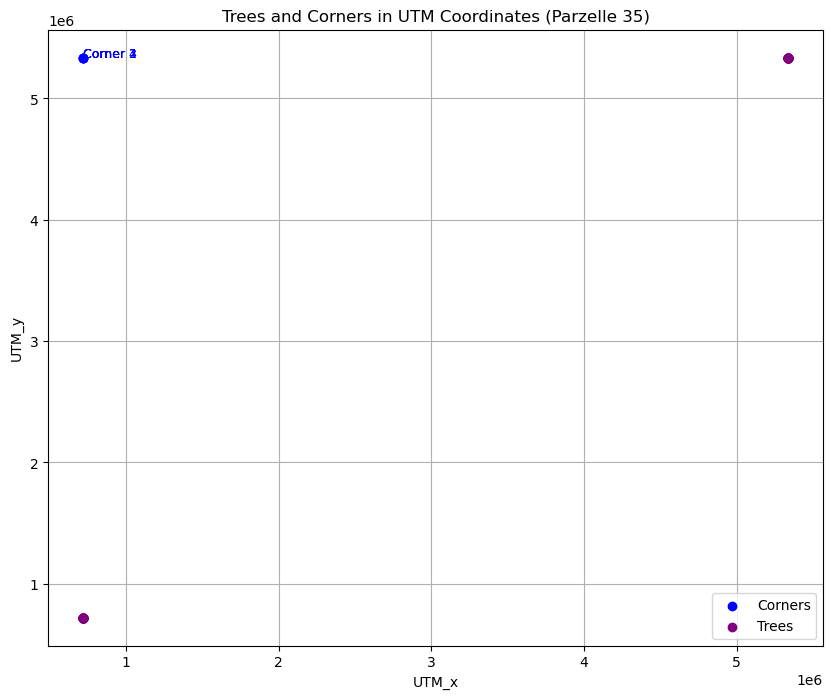

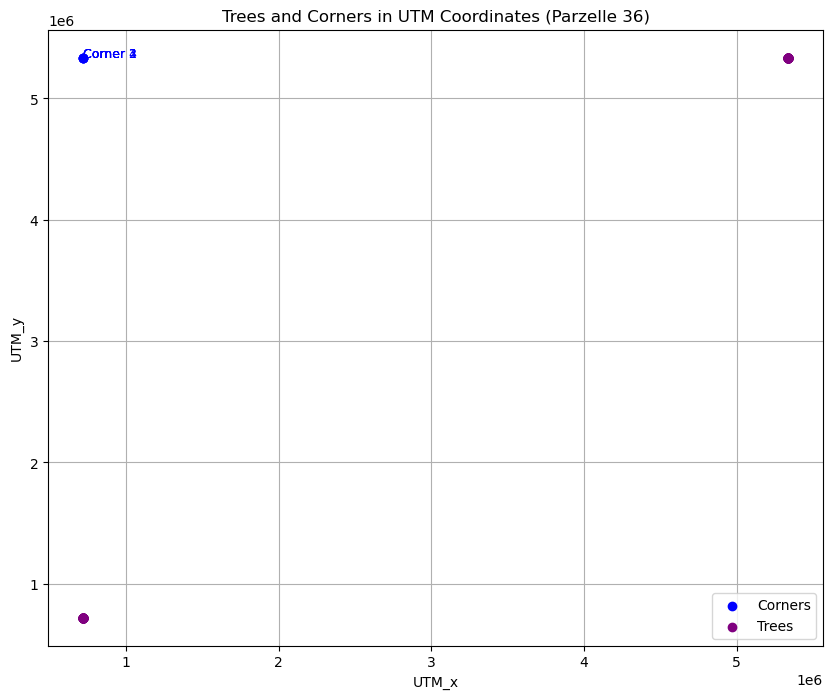

In [12]:
# Assuming `corners` and `trees` are retrieved and transformed
visualize_all_parzellen(corners, transformed_trees)


In [26]:
# Find ground line points
utm_lower_left, utm_lower_right = find_ground_line(corners[:4])

# Output
print("Lower Left (UTM):", utm_lower_left)
print("Lower Right (UTM):", utm_lower_right)

Lower Left (UTM): (720348.793, 5334838.81)
Lower Right (UTM): (720358.364, 5334885.64)


In [27]:
# Compute the ground vector and unit vector
ground_vector = np.array([utm_lower_right[0] - utm_lower_left[0], utm_lower_right[1] - utm_lower_left[1]])
ground_length = np.linalg.norm(ground_vector)
unit_ground_vector = ground_vector / ground_length

# Compute the perpendicular vector
perpendicular_vector = np.array([-unit_ground_vector[1], unit_ground_vector[0]])

In [28]:
# Transform tree coordinates
def transform_trees(trees_local, utm_lower_left, unit_ground_vector, perpendicular_vector):
    transformed_trees = []
    for tree in trees_local:
        parzelle, nr, x, y, _ = tree
        utm_x = utm_lower_left[0] + x * unit_ground_vector[0] + y * perpendicular_vector[0]
        utm_y = utm_lower_left[1] + x * unit_ground_vector[1] + y * perpendicular_vector[1]
        transformed_trees.append((parzelle, nr, utm_x, utm_y))
    return transformed_trees

In [29]:
# Perform transformation
trees_utm = transform_trees(trees[:62], utm_lower_left, unit_ground_vector, perpendicular_vector)

# Print transformed tree UTM coordinates
for tree in trees_utm:
    print(tree)

(1, 1001, 720343.2284648679, 5334840.049333123)
(1, 1002, 720347.4499555094, 5334841.227898039)
(1, 1003, 720343.3257155236, 5334844.520411584)
(1, 1004, 720344.7316728459, 5334852.398436965)
(1, 1005, 720348.1757989088, 5334855.266884989)
(1, 1006, 720351.4912045302, 5334855.50789446)
(1, 1007, 720347.0859067668, 5334861.919863718)
(1, 1008, 720350.171749002, 5334863.53466482)
(1, 1009, 720348.1493146374, 5334867.622422526)
(1, 1010, 720353.8604502699, 5334868.598605101)
(1, 1011, 720350.9498098014, 5334871.336883081)
(1, 1012, 720349.5445493815, 5334872.950958829)
(1, 1013, 720350.0515783184, 5334876.930019243)
(1, 1014, 720354.609185682, 5334878.754360332)
(1, 1015, 720353.0072521045, 5334884.899587524)
(1, 1016, 720345.3366224148, 5334884.323883464)
(1, 1017, 720349.6453657416, 5334882.932937402)
(1, 1018, 720345.6555825593, 5334880.890476326)
(1, 1019, 720348.5147293473, 5334879.897864714)
(1, 1020, 720345.4381889097, 5334875.831549532)
(1, 1021, 720343.7440171659, 5334874.0343917

In [30]:
def visualize_parzelle(corner_points, tree_points):
    """
    Visualizes the corner points in blue and tree points in purple for Parzelle 1.

    Args:
        corner_points (list of tuples): [(Parzelle, Nr, UTM_x, UTM_y), ...]
        tree_points (list of tuples): [(Parzelle, Nr, UTM_x, UTM_y), ...]
    """
    # Filter for Parzelle 1
    corners_parzelle_1 = [p for p in corner_points if p[0] == 1]
    trees_parzelle_1 = [t for t in tree_points if t[0] == 1]

    plt.figure(figsize=(10, 8))

    # Plot corners
    corner_x = [p[2] for p in corners_parzelle_1]
    corner_y = [p[3] for p in corners_parzelle_1]
    plt.scatter(corner_x, corner_y, color="blue", label="Corners")
    for i, (px, py) in enumerate(zip(corner_x, corner_y)):
        plt.text(px, py, f"Corner {i+1}", fontsize=9, color="blue")

    # Plot trees
    tree_x = [t[2] for t in trees_parzelle_1]
    tree_y = [t[3] for t in trees_parzelle_1]
    plt.scatter(tree_x, tree_y, color="purple", label="Trees")

    # Labels and legend
    plt.xlabel("UTM_x")
    plt.ylabel("UTM_y")
    plt.title("Trees and Corners in UTM Coordinates (Parzelle 1)")
    plt.legend()
    plt.grid(True)
    plt.show()


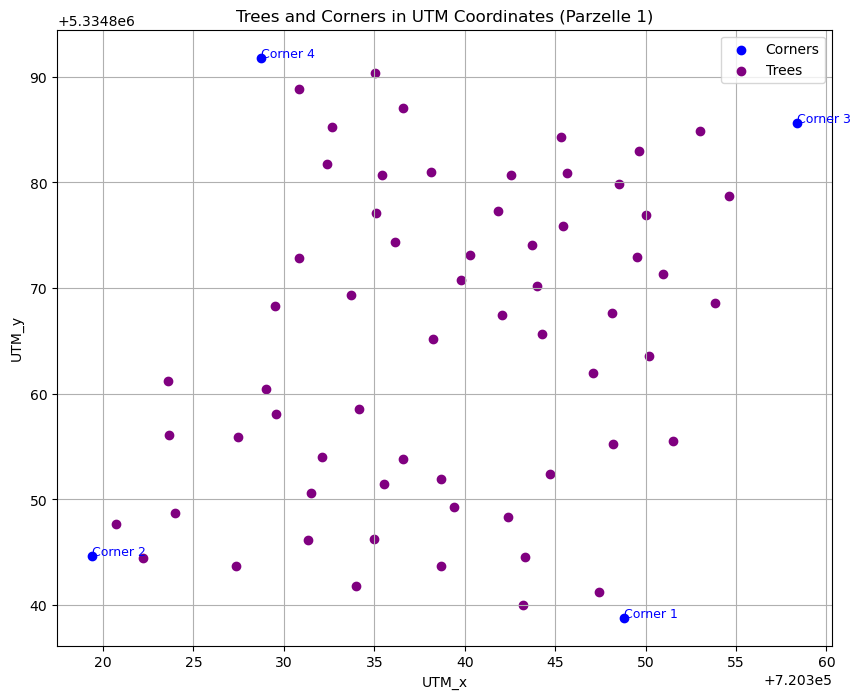

In [31]:
# Call the function to visualize
visualize_parzelle(corners[:4], trees_utm)

In [44]:
trees

[(1, 1001, 0.10000000149011612, 5.699999809265137, None),
 (1, 1002, 2.0999999046325684, 1.7999999523162842, None),
 (1, 1003, 4.5, 6.5, None),
 (1, 1004, 12.5, 6.699999809265137, None),
 (1, 1005, 16.0, 3.9000000953674316, None),
 (1, 1006, 16.899999618530273, 0.699999988079071, None),
 (1, 1007, 22.299999237060547, 6.300000190734863, None),
 (1, 1008, 24.5, 3.5999999046325684, None),
 (1, 1009, 28.100000381469727, 6.400000095367432, None),
 (1, 1010, 30.200000762939453, 1.0, None),
 (1, 1011, 32.29999923706055, 4.400000095367432, None),
 (1, 1012, 33.599998474121094, 6.099999904632568, None),
 (1, 1013, 37.599998474121094, 6.400000095367432, None),
 (1, 1014, 40.29999923706055, 2.299999952316284, None),
 (1, 1015, 46.0, 5.099999904632568, None),
 (1, 1016, 43.900001525878906, 12.5, None),
 (1, 1017, 43.400001525878906, 8.0, None),
 (1, 1018, 40.599998474121094, 11.5, None),
 (1, 1019, 40.20000076293945, 8.5, None),
 (1, 1020, 35.599998474121094, 10.699999809265137, None),
 (1, 1021, 